# **Generative Adverserial Networks**
#### Patric Gustafsson (608728) and Joel Sjöberg (610316)

Generative adverserial networks (GAN)s are a relatively new kind of network for deep learning. Originally introduced in 2014 by Goodfellow et al. [(1)][1]. 

A GAN consists of two components. A *discriminator* and a *generator*. The discriminator can be seen as a sort of police. It will try to distinguish between real and "fake" data generated by the generator. The goal of the generator is to generate data that is so close to the real data that the discriminator cannot distinguish between the two. In this sense we get a competition between the discriminator and the generator, in which the generator tries to fool the discriminator and the discriminator tries to detect the falsified data from the generator. 

Goodfellow explained the goal of GANs to be the transformation of $p_{model}$ into $p_{data}$, where $p_{model}$ is the distribution of our model and $p_{data}$ is the unknown distribution of the data we wish to discover. The training data follows a distribution $\hat{p}_{data}$ which is an empirical estimate of the underlying true distribution $p_{data}$. While the theoretical goal of the training is to have $p_{data} = p_{model}$, this is difficult to achieve since the data's distribution is unknown, so instead the goal of the training is to come as close as possible to $p_{data}$. The difficulty of this task is dependent on the data we want to generate. MNIST probably has a simpler distribution than, for example, the ImageNet database.

The generator will attempt to generate samples using $p_{model}$, by fooling the discriminator which has learned to recognize the training data $\boldsymbol{X}$. In order to generate believable samples, the generator is given a random input vector $\boldsymbol{z}$ of size $(100, 1)$, which is sampled from a gaussian distribution. This distribution has a mean of $0$ and a standard deviation of $1$. In principle, this input layer can have any shape, however the size we have chosen is fairly common. The generators' structure can be freely chosen, the only requirement is in the output layer which must be the shape of the data we want to generate.

The discriminator, like the generator, can have any freely chosen structure however the input layer needs to be equal to the size of the training data examples and the output layer should be one neuron dedicated to the output probability. The discriminator is a model trained to recognize data taken from  $\boldsymbol{X}$ by producing a probability as output (a scalar between $[0, 1]$).

## The GAN learning process


Because we want the discriminator to be able to distinguish between the real and fake data, we will train it to maximize its probability that it labels data from the original distribution and the GAN's distribution $p_{model}$ correctly. That is, given a sample from the original data distribution $x \sim p_{data}(\boldsymbol{X})$ we want to maximize $\log(D(\boldsymbol{x}))$, since we want the discriminator to classify samples from the original distribution as real examples. At the same time, we want to minimize the probability that the discriminator classifies a sample $x \sim p_{model}$ as correct. Thus we maximize $(1 - \log(D(G(\boldsymbol{z})))$, where $\boldsymbol{z}$ is sampled from $p_{\boldsymbol{z}}$, which is the gaussian distribution we defined as input earlier.

The generator should then be trained to minimize $1 - \log(D(G(\boldsymbol{z})))$ since its goal is to trick the discriminator into thinking that the sample actually came from the original distribution. In other words, the generator learns to produce a vector which can be used to make the discriminator produce a probability of 1.

The training process is defined in the following way (displayed in the figure below). Note that the discriminator is trained simply by feeding in batches of training examples, while the generator is somewhat more complex, and we explain it more in depth later.

>There are two processes involved:
 * We first train the discriminator to recognize images drawn from the training data. This is shown in the upper parts of the figure below.
 * We then combine the two models and train the generator by measuring the error in the discriminator after giving it a generated image. The gradient is then calculated by finding the error in the discriminators output, with which only the generator model is updated while discriminator remains constant. This is because we train the two models separately, in order to allow them to 'compete' with each other. Shown in the lower part of the figure. 


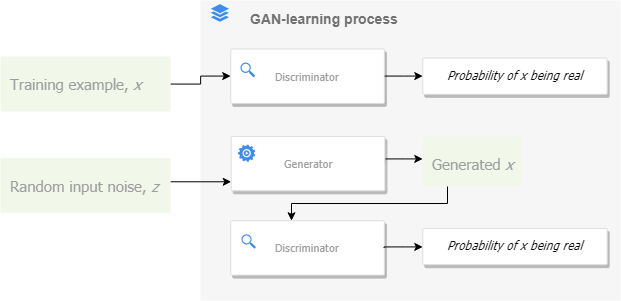

[1]: https://arxiv.org/pdf/1406.2661.pdf "Goodfellow 2014"

In [21]:
from keras import layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, Reshape, LeakyReLU, Activation, Dropout
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from keras.models import Sequential, Model
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras.activations import relu, tanh, sigmoid
from keras.datasets import mnist, cifar10, fashion_mnist
from keras import backend as K
import tensorflow as tf
from keras import *

# Utility functions

Here we list a few utility functions for displaying results of the training process



*   ```generate_imgs:``` This method generates $10$ images with the generator and plots them.
        
*   ```plot_reals_and_fakes:``` Plots $10$ images, $5$ of which are generated and the $5$ others are images taken from the training data
* ```plot_GAN_history:``` Plots the discriminator's history against the generator's history



In [22]:
# Generates a set of images from the generator and plots them.
# Input:
# generator   The generator that will produce the images. 
# noise       List of noise vectors to feed into the generator.
def generate_imgs(generator, noise):
  noise_sz = len(noise)
  
  fig = plt.figure(figsize=(10, 10))
  fakes = generator.predict(noise)
  
  # Normalizes values from range [-1, 1] into [0, 1] I think
  norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)
  
  for i, img in enumerate(fakes, 1):
    fig.add_subplot(5, 5, i)
    
    if fakes[0].shape[2] == 3:
      plt.imshow(norm(fakes[i - 1].reshape(fakes[0].shape)))
    else:
      plt.imshow(norm(fakes[i - 1].reshape(fakes.shape[1], fakes.shape[2])), cmap="gray")
    
  plt.show()
  
# Plots real and fakes images in a collage.
# generator    The generator.
# examples     The real images
def plot_reals_and_fakes(generator, examples):
  nr_of_imgs = 25
  noise = np.random.normal(size = (nr_of_imgs, 100))
  
  # We believe this normalizes values from range [-1, 1] into [0, 1]
  norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)
  gen_imgs = generator.predict(noise)
  np.random.shuffle(examples)
  real_imgs = examples[0:nr_of_imgs]

  imgs = np.vstack((gen_imgs, real_imgs))
  np.random.shuffle(imgs)
  fig = plt.figure(figsize=(10, 10))

  for i, img in enumerate(imgs, 1):
      plt.axis('off')
      fig.add_subplot(10, 5, i) 
      if img.shape[2] == 3:
        plt.imshow(norm(img.reshape(img.shape)))
      else:
        plt.imshow(norm(img.reshape(img.shape[0], img.shape[1])), cmap="gray")
   
  plt.axis('off')
  plt.show()
  
# Plots the loss of the GAN 
# disc_hist    Loss history for the discriminator
# gen_hist     Loss history for the generator
def plot_GAN_history(disc_hist, gen_hist):
  plt.figure(figsize = (15, 10))
  plt.plot(disc_hist)
  plt.plot(gen_hist)
  plt.title('Model accuracy')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Discriminator Loss', 'Generator Loss'], loc='upper right')
  plt.show()

# Loading the data

Keras comes with a few labeled training sets that we will use, here we load MNIST and CIFAR10.


*   MNIST is a collection of handwritten digits between 0 and 9
*   CIFAR10 is a collection of images portraying different vehicles and animals also divided into 10 classes.

### Preprocessing the data

Commonly, it is good practice to preprocess the data you train with. We use normalization to clamp values between -1 and 1. Normally we would use values between 0 and 1 but allowing for negative values appears to change generator performance favorably.

Our method allows for use of both RGB and grayscale images. If RGB-images are used, the method needs to add an extra axis for the color values for each image.


In [23]:
# Normalizes image values into [-1, 1] range. 
# img_d    Tensor with images
# rgb      True if the images are RGB-images, false otherwise
def format_img_data(img_d, rgb=False):
  if not rgb:
    img_d = img_d.reshape(img_d.shape[0], img_d.shape[1], img_d.shape[2], 1)
  else: 
    img_d = img_d.reshape(img_d.shape[0], img_d.shape[1], img_d.shape[2], 3)
  
  img_d = img_d.astype('float32')
  
  scale_factor = 127.5
  img_d -= scale_factor
  img_d /= scale_factor
  
  return img_d

In [24]:
# MNIST
(train_mnist, _), _ = mnist.load_data()
train_mnist = format_img_data(train_mnist, False)
print("MNIST shape: ", train_mnist.shape)

# CIFAR10
(train_cifar, train_cifar_labels), _ = cifar10.load_data()
train_cifar = format_img_data(train_cifar, True)
print("CIFAR10 shape: ", train_cifar.shape)


MNIST shape:  (60000, 28, 28, 1)
CIFAR10 shape:  (50000, 32, 32, 3)


# Multilayer Perceptron
## Generating MNIST
We will begin by generating MNIST digits using a simple MLP network. 

The generator as explained earlier takes in a random noise vector and outputs an image in the given format. The input vector $\boldsymbol{v}$ is defined as $\boldsymbol{v} = (v_1, v_2, \ldots, v_{100})^T$. Each $v_i$ is sampled from a standard normal distribution. MNIST digits are of size $28 \times 28$, which is the output size of the generator. 




In [6]:
# Constructs a generator for MNIST.
# img_shape    img_shape Shape of the images to be generated
def make_generator(img_shape):
  model = Sequential()
  
  # link to model: https://skymind.ai/wiki/generative-adversarial-network-gan, works OK but very simple. Can probably be imroved.
  model.add(Dense(256, input_shape=(100, )))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))
  
  return model
  

## The Discriminator

The discriminator works as follows: 
It receieves an image of size *img_shape* and predicts whether the image is a generated image or not. Thus, the discriminator is a binary classifier. Like the generator, the discriminator is a MLP with an input matrix $\boldsymbol{A}$ where $\boldsymbol{A}$ is a tensor of size $(28,28)$. It produces a scalar value between $0$ and $1$. Where values closer to one signify real images.

In [7]:
# Constructs a discriminator for MNIST.
# img_shape    img_shape Shape of the input images
def make_discriminator(img_shape):

  model = Sequential()
  
  # link to model: https://skymind.ai/wiki/generative-adversarial-network-gan
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4)) # Francois Chullet suggests adding dropout to the discriminator
  model.add(Dense(1, activation='sigmoid'))
  
  return model  

For data containing more abstract features, we noticed the simpler architecture did not produce satisfying results. Therefore, we use a slightly more advanced architecture for CIFAR10. 

The architecture is known as Deep Convolutional Generative Adversarial Networks (DCGAN) and is one commonly used structure for generating images. A small disadvantage of GANs is that it is often not possible to transfer one architecture from one problem to another. This is because the convolutional layers will have different shapes depending on the output image generated.

To make our life somewhat easier we will also generate images from only one of the ten classes that the CIFAR10 dataset contains. There is not so much use in coming up with your own model for this, rather we adapt one that is readily available. The generator and discriminator below follow the DCGAN structure. 

In [8]:
# Generator methods must accept img_shape as a parameter even though they don't use it.
# This is so our code don't break. 
def make_generator_DCGAN_cifar(img_shape):
    model = Sequential()
    
    # First, transform the input into a 16x16 128-channels feature map
    model.add(layers.Dense(256 * 2 * 2, input_shape=((100, )), activation='relu'))
    model.add(layers.Reshape((2, 2, 256)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation='relu'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation='relu'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation='relu'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation='tanh'))

    return model

In [9]:
def make_discriminator_DCGAN_cifar(img_shape):
    model = Sequential()

    model.add(layers.Conv2D(32, kernel_size=5, strides=2, input_shape=img_shape, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4)) # According to Fchollet, important to have dropout as the last layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

### Training the GAN

The basic principle of GAN's is to train the discriminator for a few epochs to make sure it can discriminate between real images and random noise. Goodfellow et al. recommends only using one epoch for training the discriminator, which we also use. 

The generator is then combined with the discriminator such that the generators output-layer becomes a hidden layer of the combined model. The models are then trained independently of each other. 

The discriminator is kept untrainable when training the combined model, since we only want to improve the generator and not the discriminator at this point. 


In [10]:
# This is how we train the generator
# Input from the generator is feed into the discriminator. 
def make_combined(discr, gen):
  model = Sequential()
  
  discr.trainable = False
  model.add(gen)
  model.add(discr)
  
  return model

### Training methods

These are general methods which can be used for any set of generator and discriminator. The only requirement is that the discriminator has an input size equal to the generators output size.

The method works by the principles described earlier.



*   ```train``` takes the pre-defined models and train them according to the method proposed by Goodfellow et al. for one epoch.


1.   The method referred to here is to train the discriminator on a set of real and fake images separately. That means we first train on a set of real images to make the model overfit slightly to what we want to produce and then give it a reference for what not accept from the generator.
2.   After that we now have the discriminator-part of the combined model updated and we can proceed by training the generator-part.
3.   In the combined model the generator's output-layer is set to the discriminator's output-layer. Updates at this stage from backpropagation will only update the generator in an attempt to tune it towards the probability distribution of the real data.
4.    Repeat for each batch


*   ```init_GAN``` takes the training data and model creation functions and returns the initialized models required for training.
* ```train_GAN``` takes hyperparameters like batch size and epochs and calls the ```train``` function for each epoch.



In [11]:
# Trains a GAN for one epoch.
#
# Input:
# nbatches      Number of minibatches to train on
# batch_size    Number of elements in each minibatch
# discr         The discriminator
# gen           The generator
# comb_model    The combined model that is actually used to train the generator
# train_data    The training data
# k             Number of iterations to train the discriminator during each minibatch
# epoch_i       Used for the loading bar to print the current epoch.
def train(train_data, nbatches, batch_size, discr, gen, comb_model, k = 1, epoch_i = 1):
  
  comb_train_labels = np.vstack((np.ones((batch_size, 1)), np.zeros((batch_size, 1))))

  err_real_hist = []
  err_fake_hist = []
  g_loss_hist = []
  
  print("Epoch: {}".format(epoch_i + 1))
    
    
  for i in range(nbatches):
    idx = np.random.choice(np.arange(len(train_data)), batch_size, replace=False)
    
    discr.trainable = True
    
    # Train the discriminator
    for i in range(k):
      fakes = gen.predict(np.random.normal(size = (batch_size, 100)))

      real_train = train_data[idx].reshape((train_data[idx].shape[0], 
                                         train_data[idx].shape[1], 
                                         train_data[idx].shape[2], 
                                         train_data[idx].shape[3]))

      fake_train = fakes.reshape((fakes.shape[0], 
                                  fakes.shape[1], 
                                  fakes.shape[2], 
                                  fakes.shape[3]))
      
      err_real = discr.train_on_batch(real_train, np.ones((batch_size, 1)))
      err_fake = discr.train_on_batch(fake_train, np.zeros((batch_size, 1)))
      
      err_real_hist.append(err_real)
      err_fake_hist.append(err_fake)
         
    # Train the generator
    discr.trainable = False
    z = np.random.normal(size = (batch_size, 100))
    g_loss = comb_model.train_on_batch(z, np.ones((batch_size, 1)))
    g_loss_hist.append(g_loss)
  
  
  avg_calc = lambda x, i: sum([y[i] for y in x]) / (nbatches)
  
  # Index for loss
  LOSS_INDEX = 0
   
  discr_real_loss = avg_calc(err_real_hist, LOSS_INDEX)
  discr_fake_loss = avg_calc(err_fake_hist, LOSS_INDEX)
  gen_loss = avg_calc(g_loss_hist, LOSS_INDEX)
  
  return (discr_real_loss, discr_fake_loss, gen_loss)  



In [12]:
def init_GAN(train_data, generator_func, discr_func, optimizer_func):
  img_shape = train_data[0].shape

  generator = generator_func(img_shape)
  generator.compile(loss="binary_crossentropy", optimizer=optimizer_func)  #lr=0.0002, beta_1=0.5

  discriminator = discr_func(img_shape)
  discriminator.compile(loss="binary_crossentropy", optimizer=optimizer_func, metrics=['accuracy'])

  # This is always the same independent of the strucutre of the generator and the discriminator
  combined_model = make_combined(discriminator, generator)
  combined_model.compile(loss="binary_crossentropy", optimizer=optimizer_func, metrics=['accuracy'])
  
  return (discriminator, generator, combined_model)

In [13]:
def train_GAN(discriminator, generator, comb_model, train_data, batch_size = 128, nepochs = 200, k = 1):
  nbatches = int(len(train_data) / batch_size)
  nr_of_imgs = 10
  noise = np.random.normal(size=(nr_of_imgs, 100)) # People seem to be using normal distribution for this

  D_Hist = []
  G_Hist = []
  for i in range(nepochs):
    metrics = train(train_data, nbatches, batch_size, discriminator, generator, comb_model, k, i)
    D_Hist.append(metrics[0])
    G_Hist.append(metrics[2])
    
    # generate plots every 5:th epoch
    if (i+1) % 5 == 0:
      generate_imgs(generator, noise)

    
  return (D_Hist, G_Hist)

# Generating MNIST
During training we plot the images generated by 10 random noise vectors chosen at the start. This makes it easier to observe how the GAN improves over time.

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


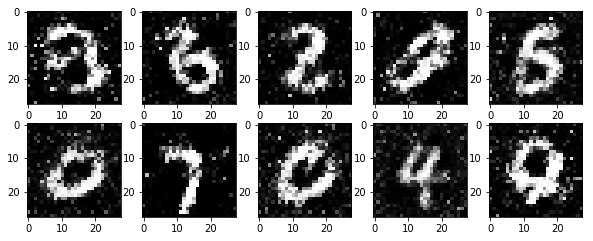

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


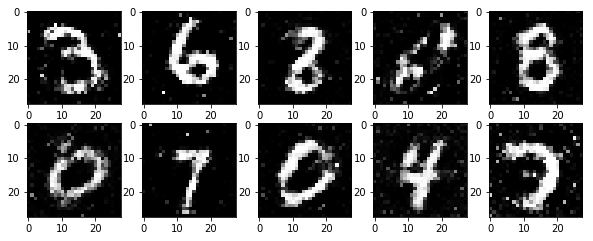

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


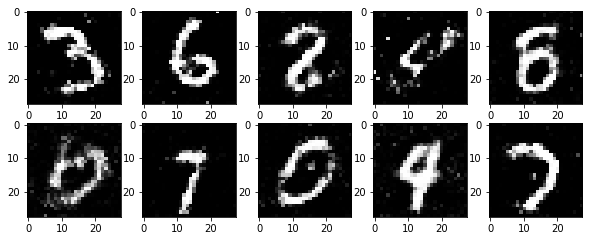

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


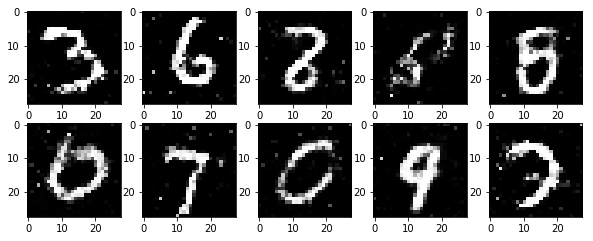

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


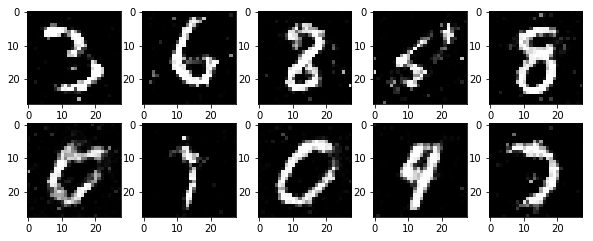

Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


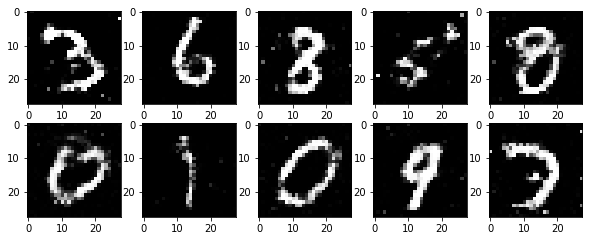

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35


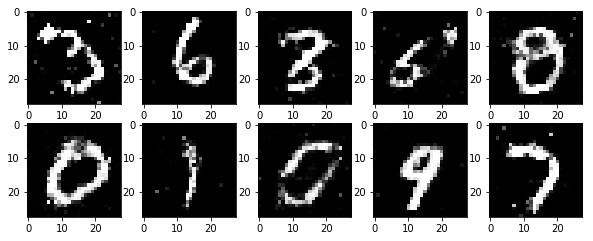

Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40


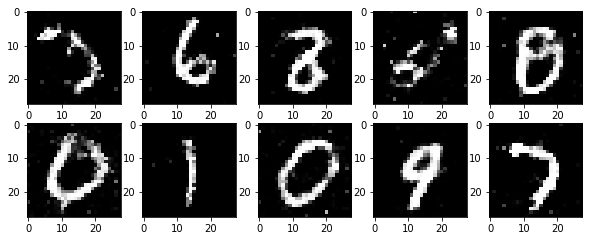

Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45


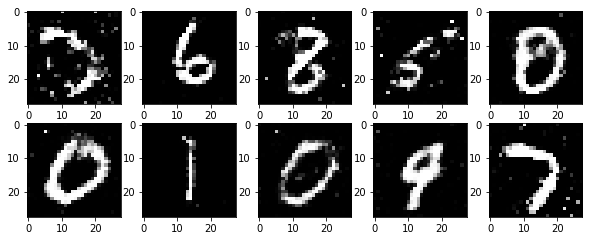

Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


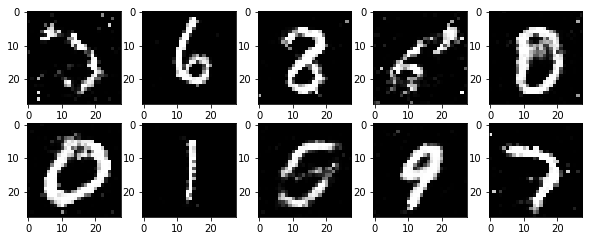

In [14]:
# Train a GAN for MNIST generation
adam = Adam(lr=0.0002, beta_1=0.2)
(discriminator, generator, comb_model) = init_GAN(train_mnist, make_generator, make_discriminator, adam)

(d_h, g_h) = train_GAN(discriminator, generator, comb_model, train_mnist, batch_size=128, nepochs=50, k=1)

### Plotting results (MNIST)
Here we show a plot of the average loss for each epoch for both the discriminator and the generator. We can see that the discriminator and generator starts converging from about the 10:th epoch. 

We also plot a collage of 50 images where half are real, and the rest are generated images. Can you spot all the fakes?

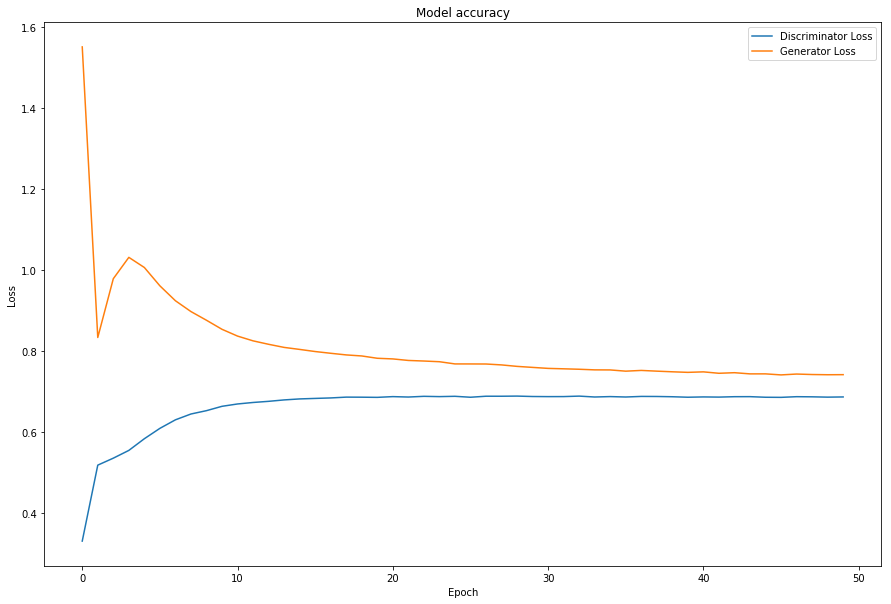

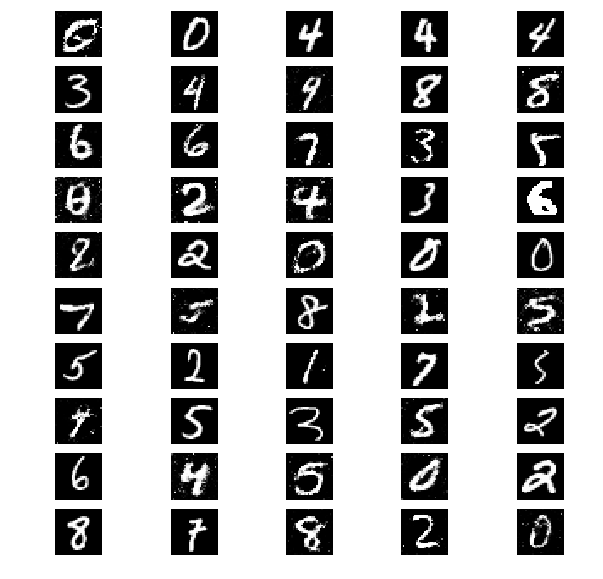

In [15]:
plot_GAN_history(d_h, g_h)
plot_reals_and_fakes(generator, train_mnist)

### MNIST discussion
As shown a simple structure can generate new images of digits that are relatively convincing. This is likely due to the simple form that each image has, where each digit is clearly distinct from the background.

The simple structure of the network allows it to be trained in a short amount of time compared to the DCGAN structure we introduce later.

# Generating CIFAR10
For CIFAR10 a MLP architecture does not have enough representation power to produce satisfying results. For this reason, we employ a more powerful GAN structure based on convolutional networks. We will here use an architecture called Deep Convolutional Generative Adversarial Networks (DCGAN) introduced by Radford et al [(2)][2]. 

[2]: https://arxiv.org/pdf/1511.06434.pdf "Radford 2014"

For the DCGAN we use the optimizer Adam, we did tests with RMSprop as well however the results are similar with Adam having a slight edge after visual inspection. 

DCGAN is a type of GAN with convolutional layers. Radford et al. proposed:


*   Replacement of pooling layers with "strided" convolutions.
*   Using batch normalization in both the generator and discriminator
*   Removal of densely connected layers
*   Relu activations for all layers in the generator, tanh in output
*   LeakyRelu in the discriminator for all layers

We also implemented a few tricks by Francois Chollet, for example: Adding a dropout layer between output and the last hidden layer to increase randomness in the discriminators estimate. Radford et al. also used a learning rate of 0.0002 with the Adam optimizer and a momentum of 0.5 in their report. 




Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


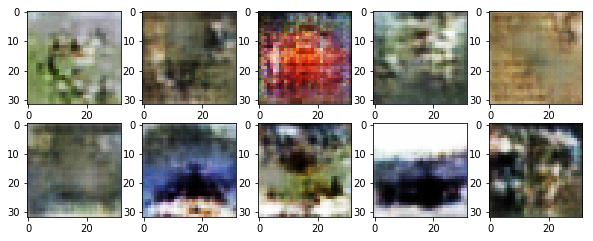

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


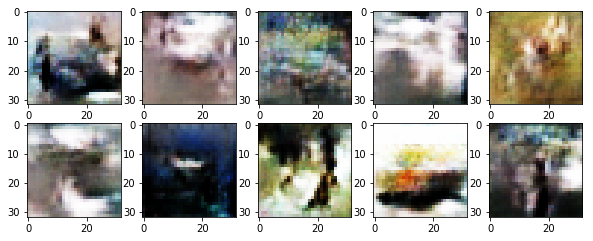

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


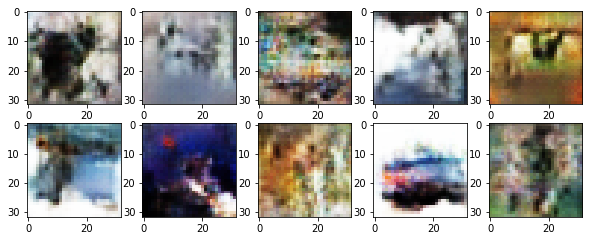

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


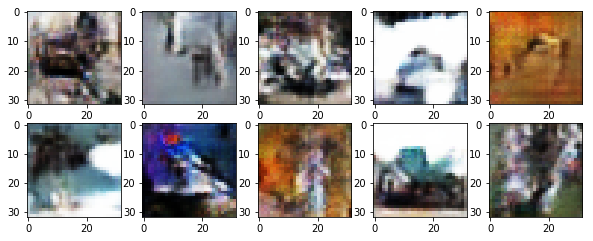

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


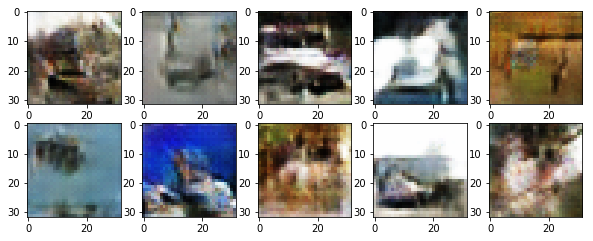

Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


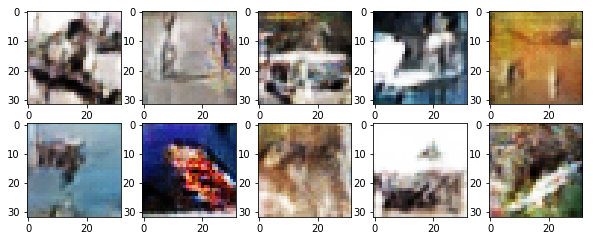

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35


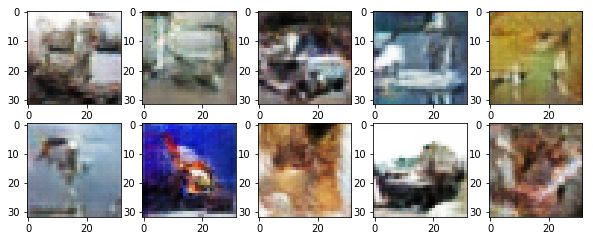

Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40


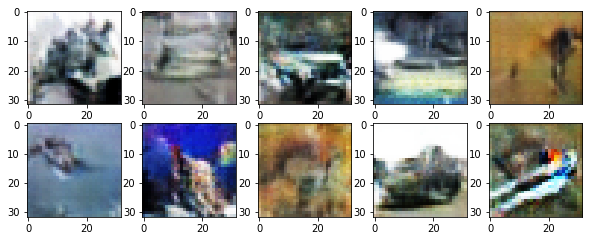

Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45


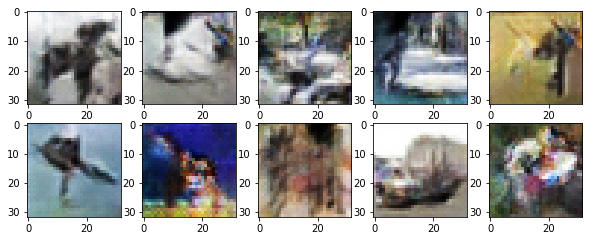

Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


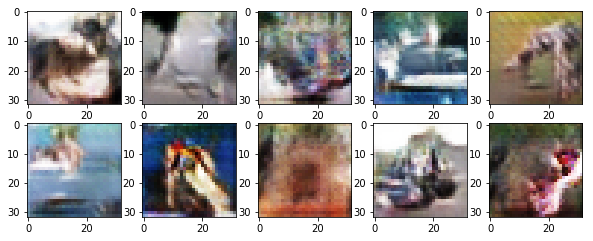

Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55


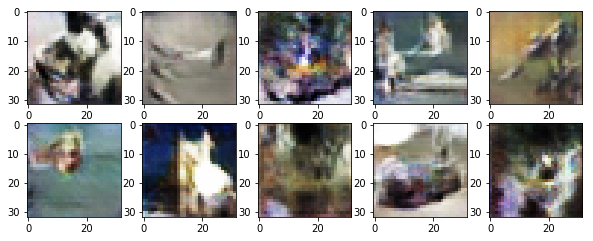

Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60


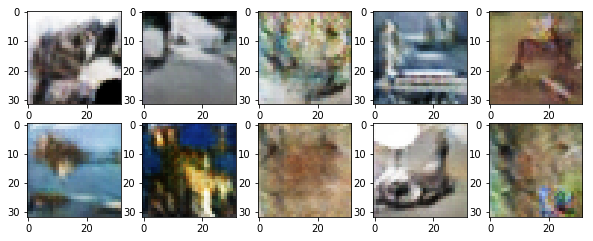

Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65


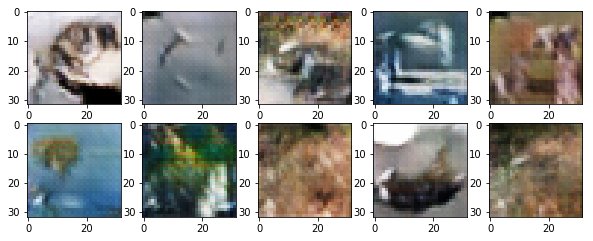

Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70


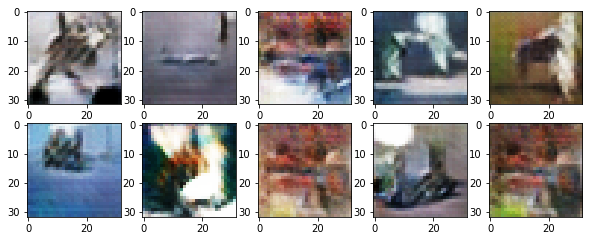

Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75


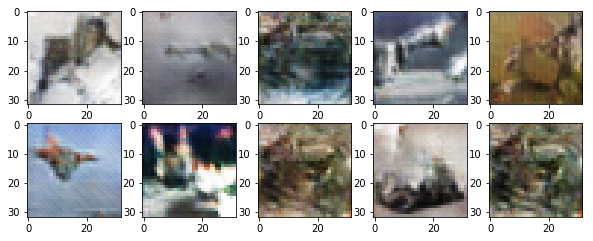

Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80


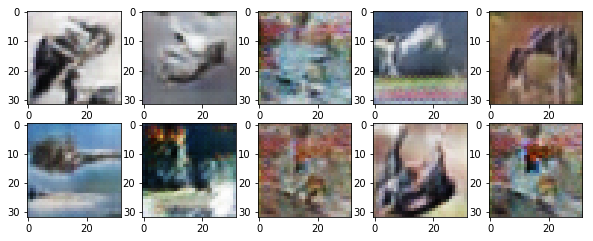

Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85


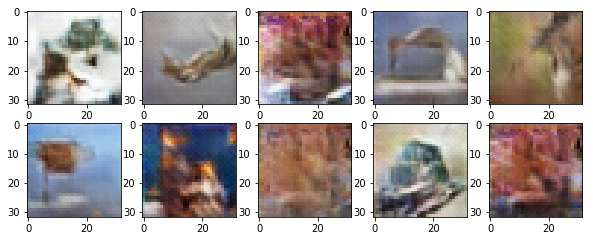

Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90


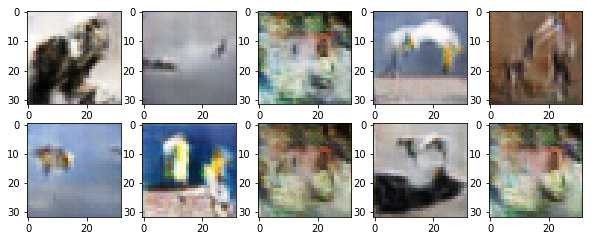

Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95


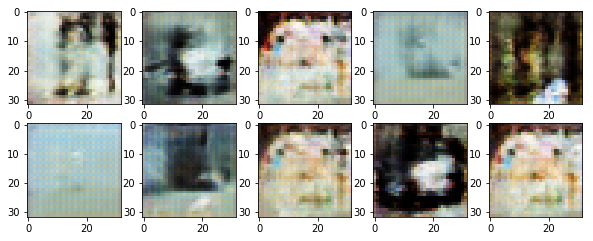

Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100


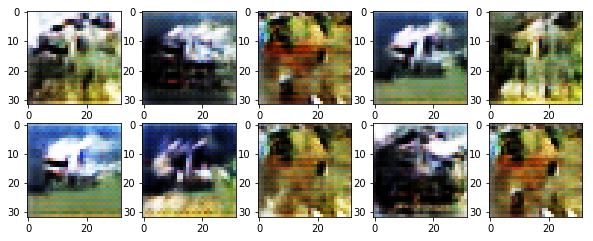

Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105


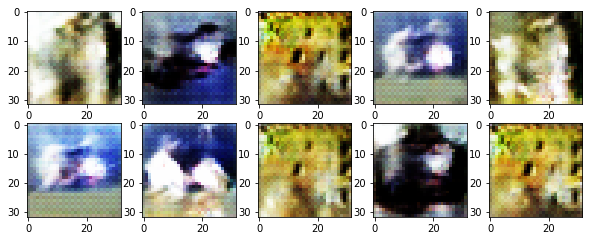

Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110


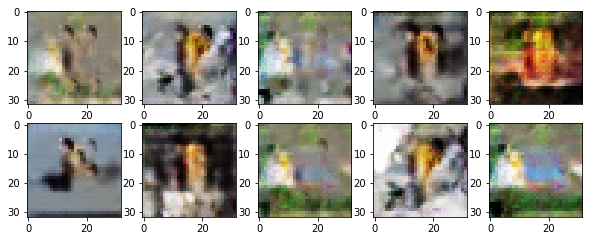

Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115


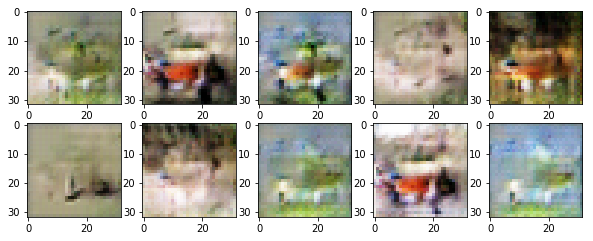

Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120


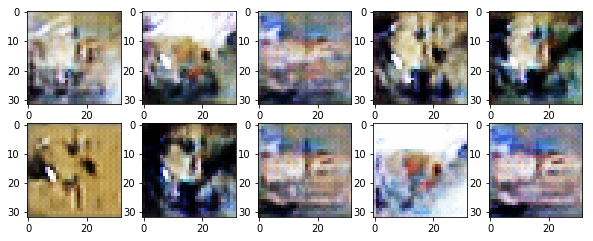

Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125


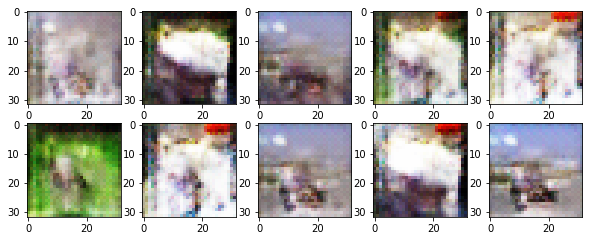

Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130


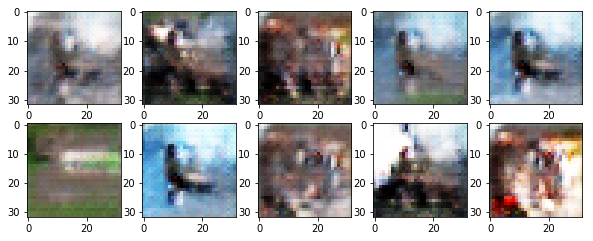

Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135


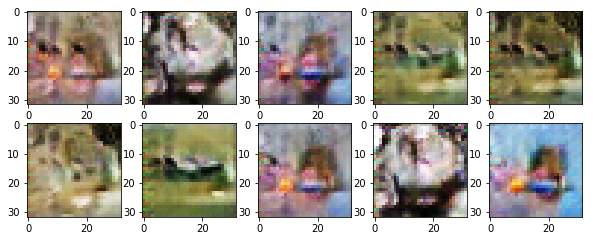

Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140


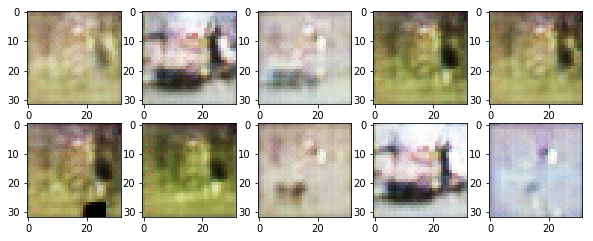

Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145


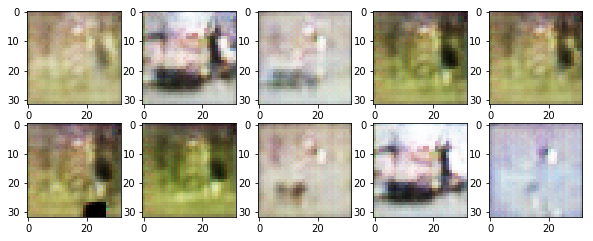

Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150


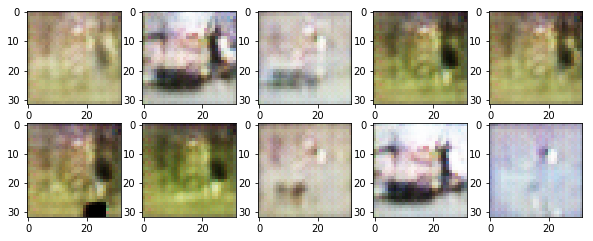

In [16]:
adam = Adam(lr=0.0002, beta_1=0.5)
rms = RMSprop(lr = 0.0008, clipvalue = 1, decay = 1e-8)

(discriminator, generator, comb_model) = init_GAN(train_cifar, make_generator_DCGAN_cifar, make_discriminator_DCGAN_cifar, adam)

(d_h, g_h) = train_GAN(discriminator, generator, comb_model, train_cifar, 128, 150)

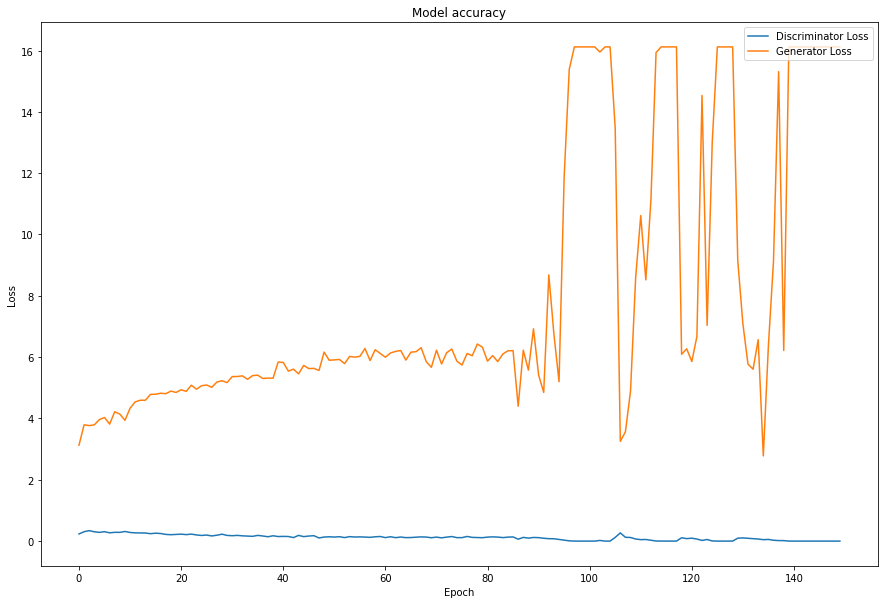

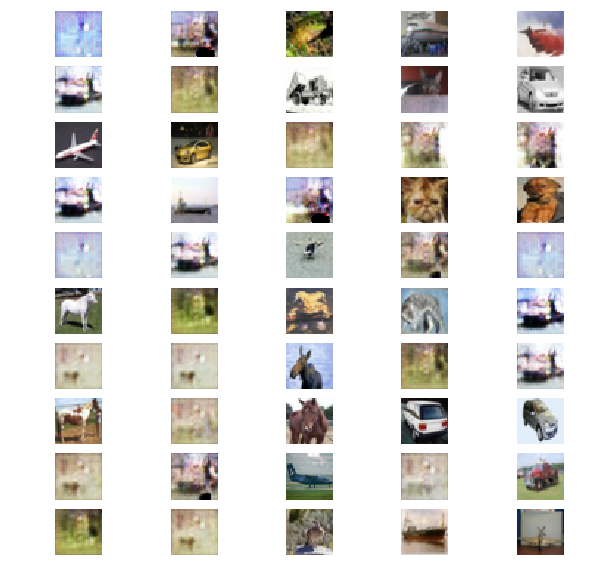

In [17]:
plot_GAN_history(d_h, g_h)
plot_reals_and_fakes(generator, train_cifar)

Ideally the accuracy of the discriminator when tested on real images and generated images should be roughly 50/50. The generator should also be capable of reaching an accuracy higher than 0. 

It seems that the network has trouble with multiple classes. It might be more reasonable to try to generate images from only one class. This is what we try to do next. 

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


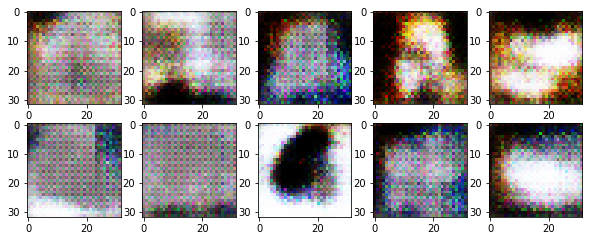

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


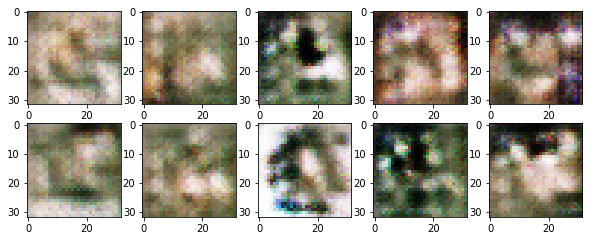

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


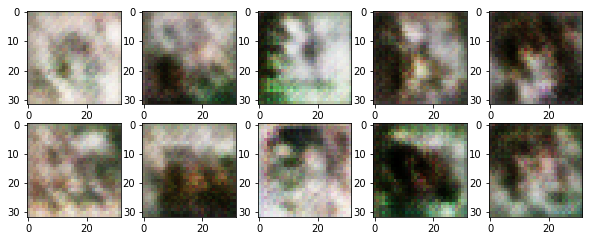

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


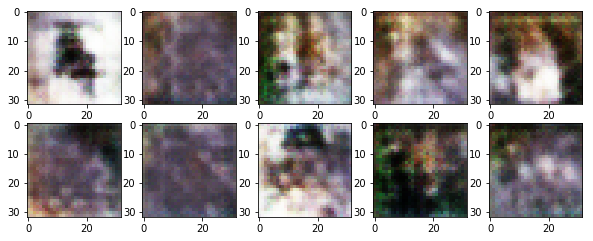

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


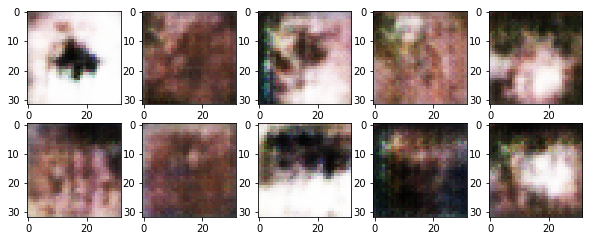

Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


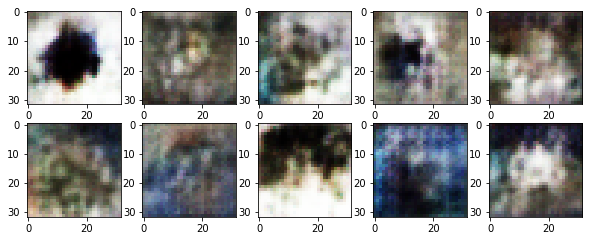

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35


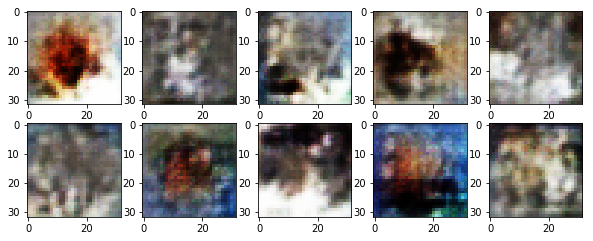

Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40


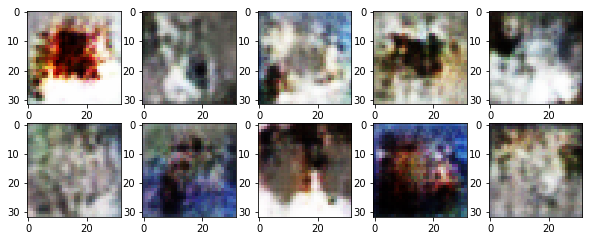

Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45


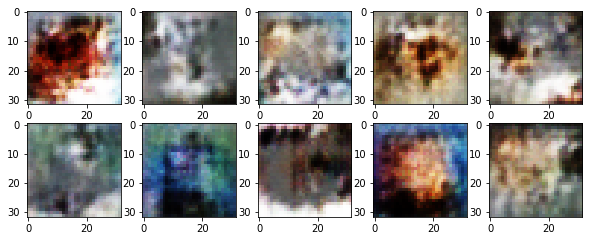

Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


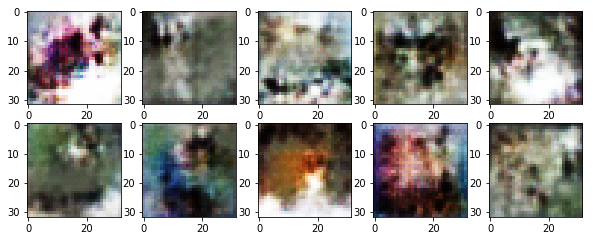

Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55


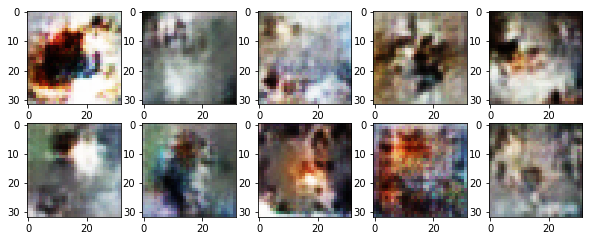

Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60


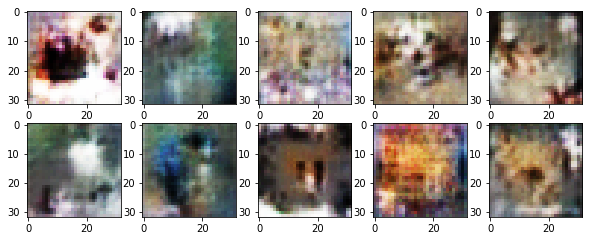

Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65


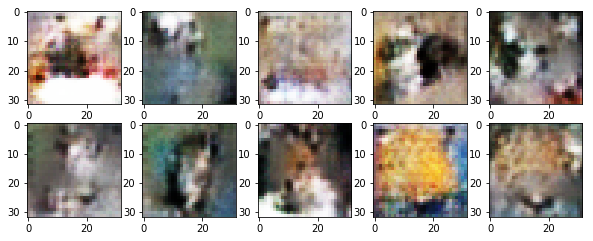

Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70


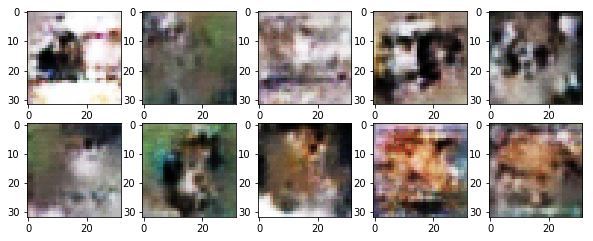

Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75


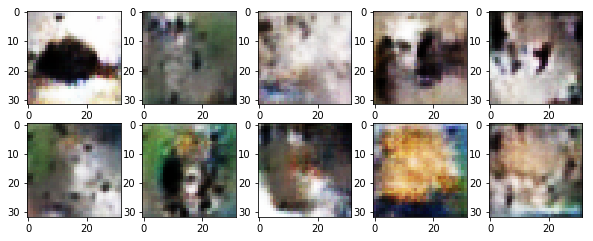

Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80


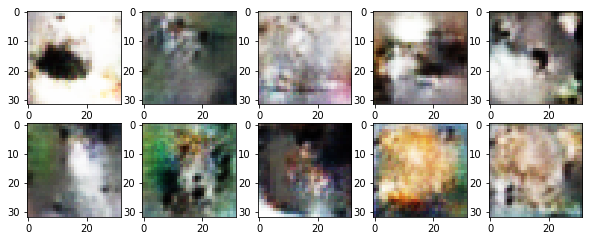

Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85


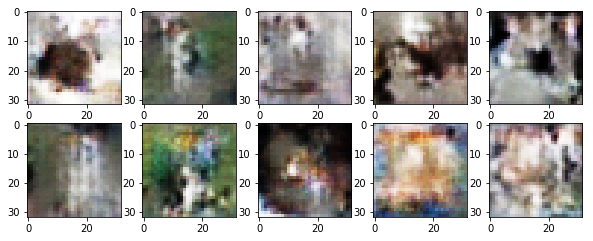

Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90


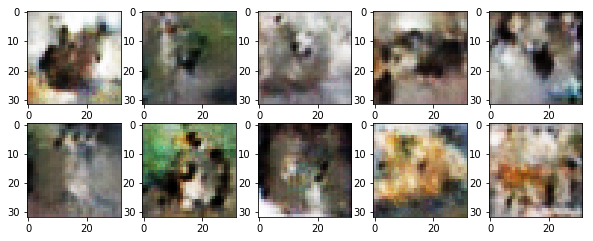

Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95


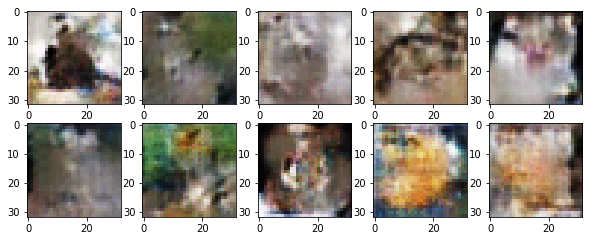

Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100


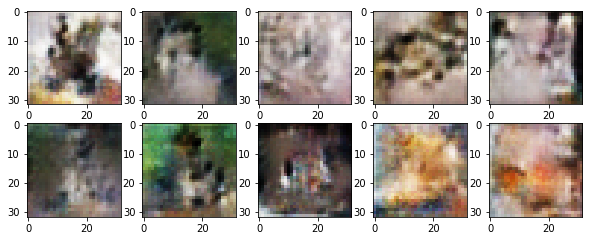

Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105


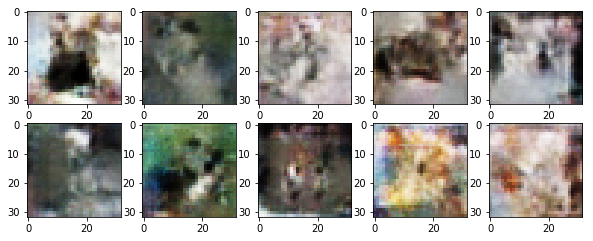

Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110


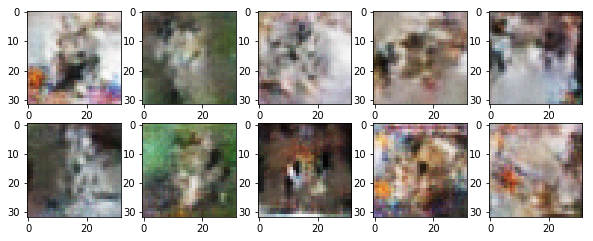

Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115


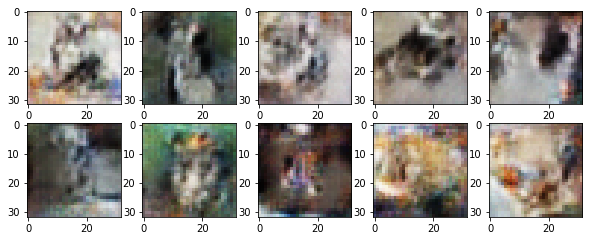

Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120


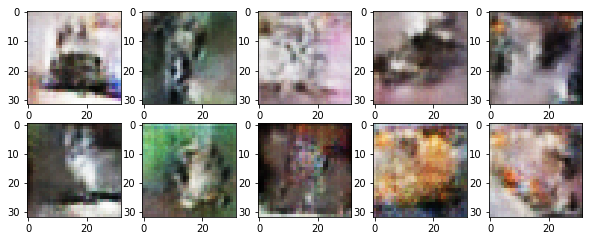

Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125


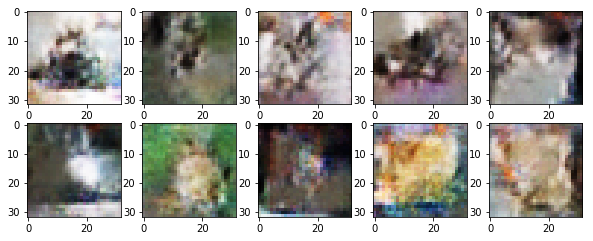

Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130


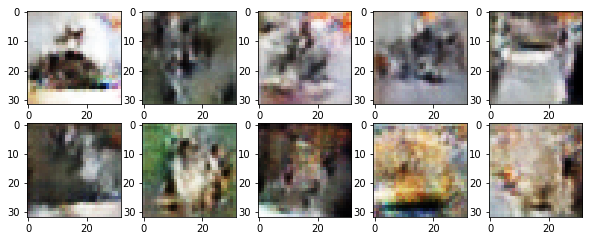

Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135


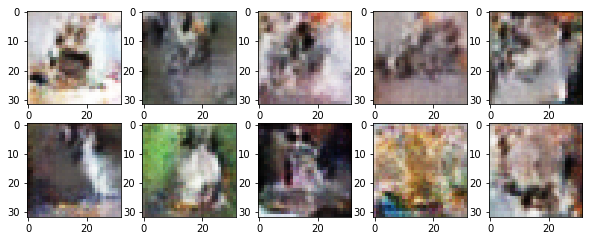

Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140


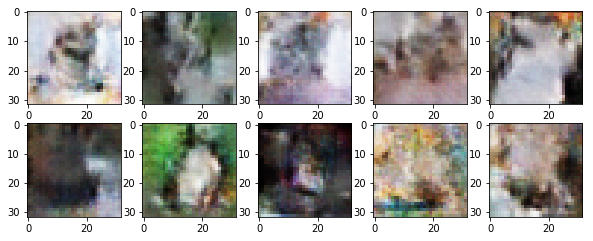

Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145


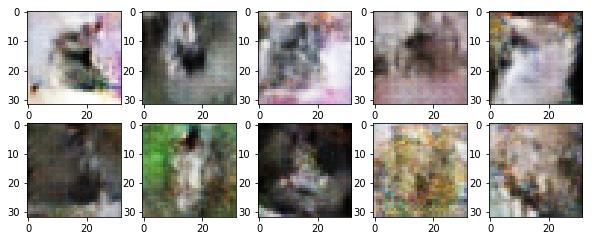

Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150


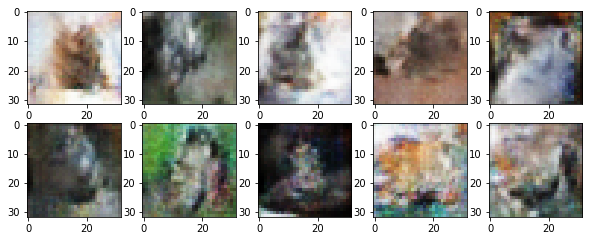

Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155


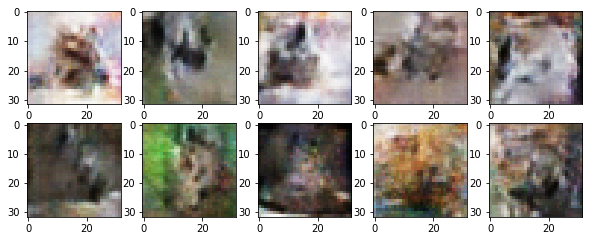

Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160


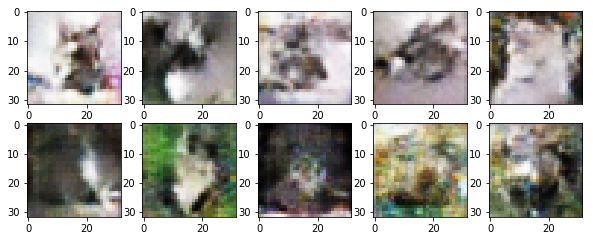

Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165


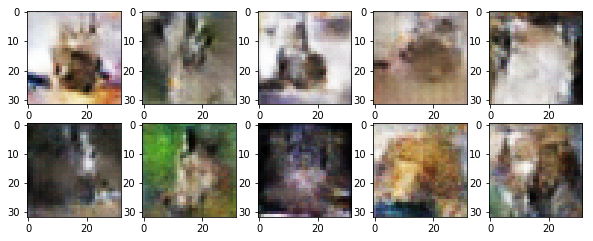

Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170


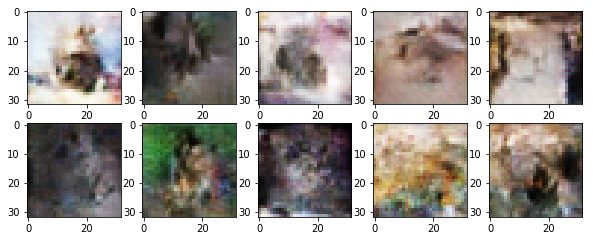

Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175


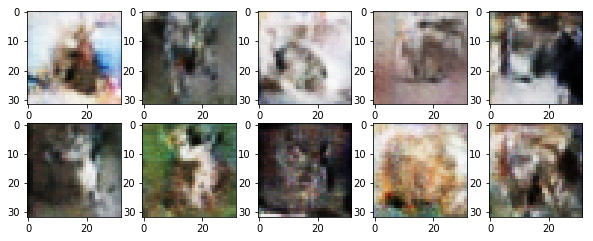

Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180


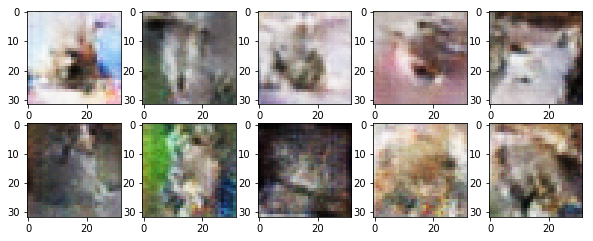

Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185


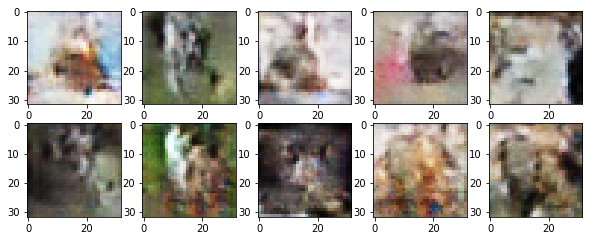

Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190


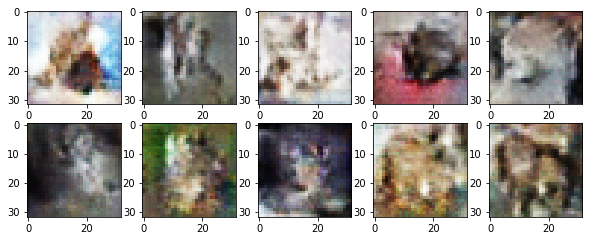

Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195


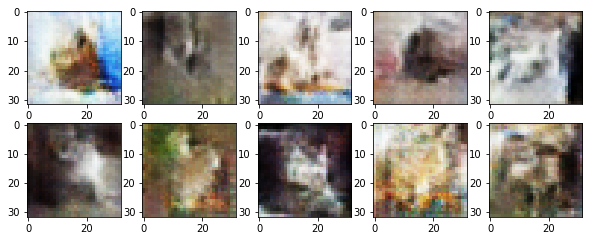

Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200


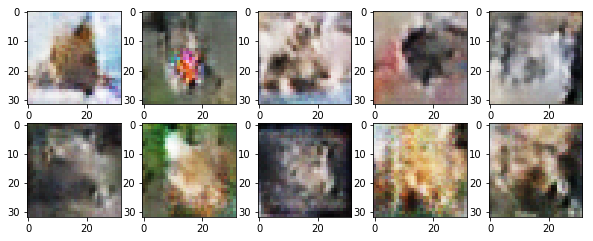

Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205


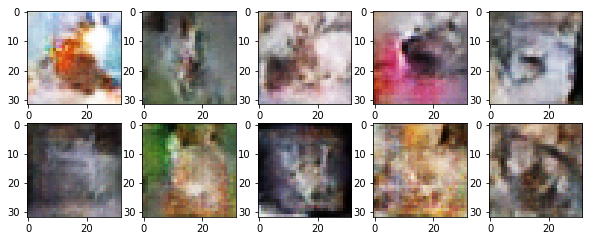

Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210


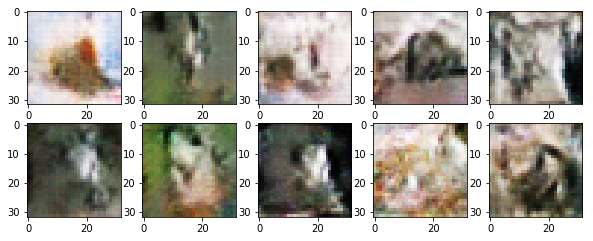

Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215


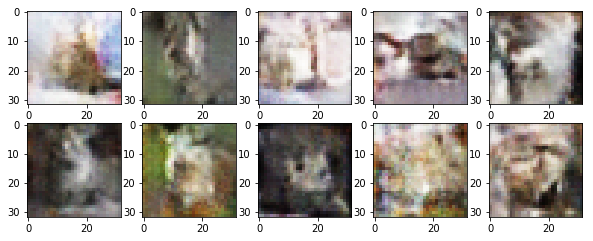

Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220


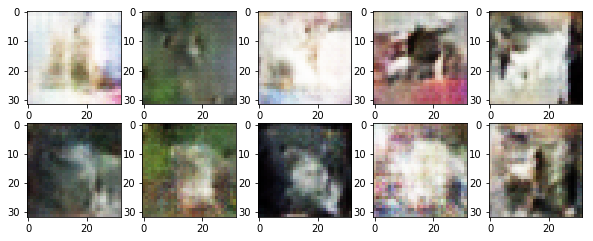

Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225


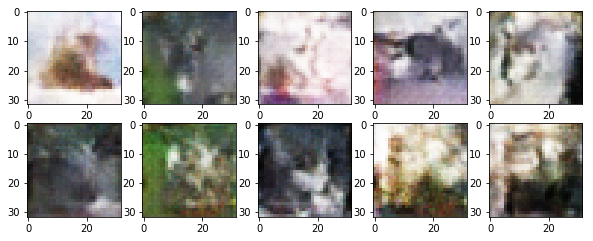

Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230


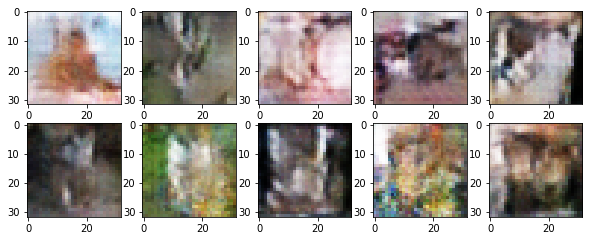

Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235


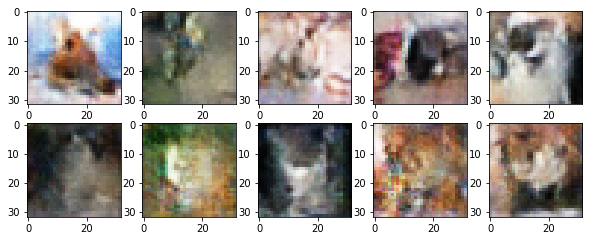

Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240


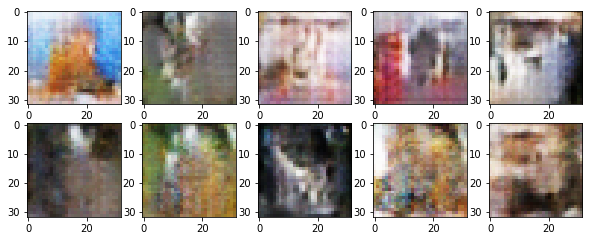

Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245


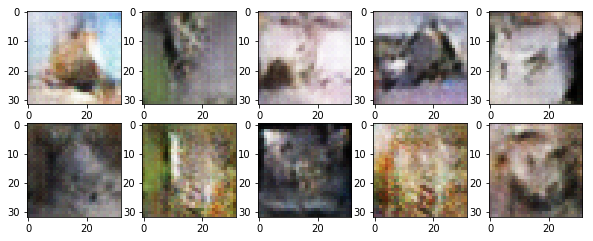

Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250


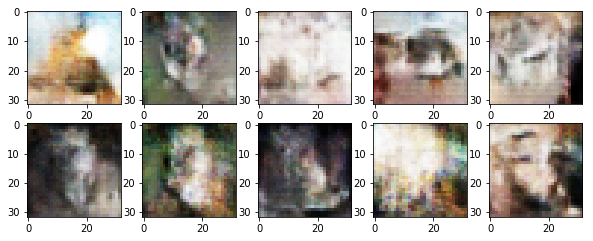

In [29]:
adam = Adam(lr=0.0002, beta_1=0.5)

train_cifar_cats = train_cifar[train_cifar_labels.flatten() == 3] # 3 is cats

(discriminator, generator, comb_model) = init_GAN(train_cifar_cats, make_generator_DCGAN_cifar, make_discriminator_DCGAN_cifar, adam)

(d_h, g_h) = train_GAN(discriminator, generator, comb_model, train_cifar_cats, 128, nepochs = 250, k = 1)


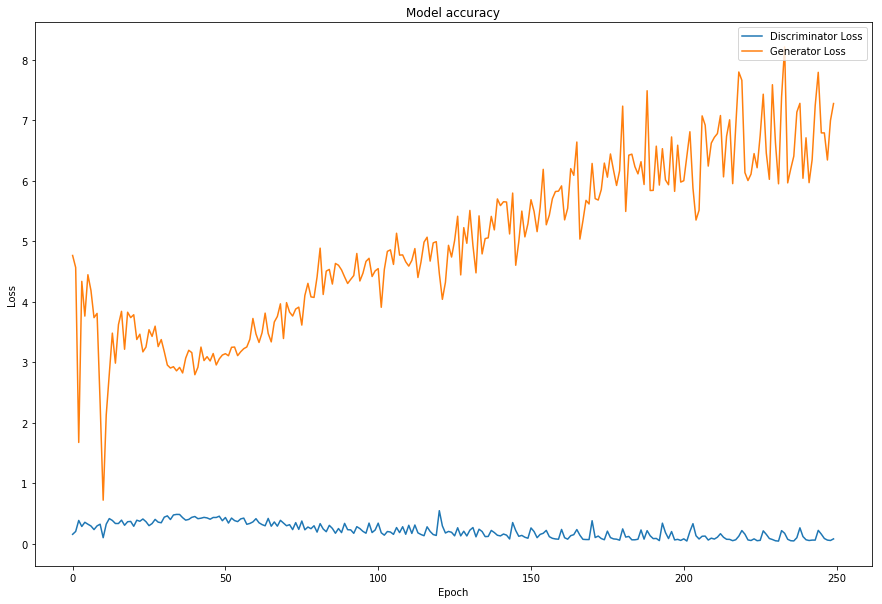

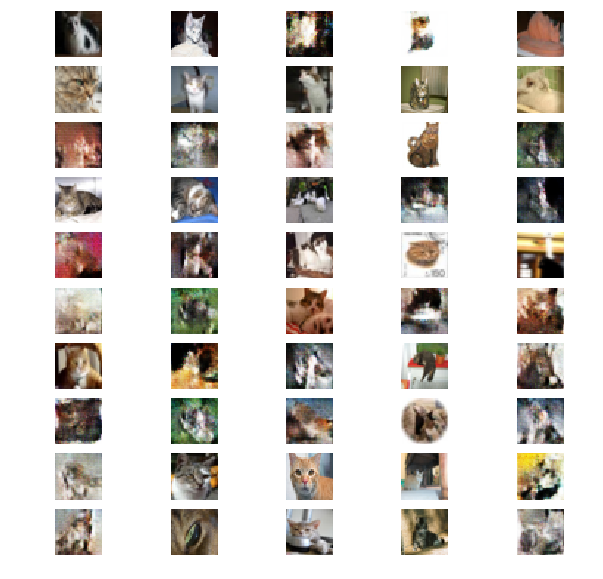

In [30]:
plot_GAN_history(d_h, g_h)

plot_reals_and_fakes(generator, train_cifar_cats)

# Conclusions

### MNIST
The images in MNIST are pretty simple to generate. The DCGAN we used for CIFAR10 did not produce good results as easily as the simple model. The DCGAN managed to generate clusters of pixels in the center of the screen when trained for approximately 20 epochs. This makes us believe that simpler models have significance when designing a network for relatively simple data.

The generator can produce quite convincing sets of images as we have shown in "Plotting results (MNIST)". Some images do however include random occurrences of bright pixels apart from the number produced. This is one method of finding generated images, some images even failed to convince us despite their resemblance to real numbers due to the "unrefined" edges.

During training we observed that the accuracy of the GAN was close to the game-theoretic equilibrium. We saw that the discriminator had about 50% accuracy on generated images, implying that it barely outperformed random guessing. 

We consider the MNIST GAN a success, with more time and resources, one could test even more hyperparameters and features. This has proven to be quite difficult as training for 100 epochs (which is a good number of epochs in our experience) takes approximately 45 minutes.

### CIFAR10

CIFAR10 proved to be a much more challenging dataset to generate than MNIST. This is possibly due to the large range of different shapes that exist even within one class. The generated images often take the general shape of the class but does seldom contain any more clearly defined features, for this reason they often appear "blocky" and are easily identified as generated, after some consideration.

The training time becomes even more of a bottleneck when using the DCGAN structure. Training with all the CIFAR10 data for 150 epochs took about 80 minutes. Thus, testing any changes was more difficult when compared to MNIST. 

Our attempt to reduce the number of classes to one improved the training time for each epoch tenfold, mostly due to there being ten times less data. The graph in this case shows a loss that at first decreased but after about the 40:th epoch it started to diverge. The generated images were almost convincing but after some inspection it was quite clear which images were generated.

Interestingly the graph displaying the loss in the first CIFAR example shows the loss of the generator increasing for some epochs and then stabilizing somewhat. It almost has the inverse appearance to the MNIST graph, it might be that the discriminator is outperforming the generator. GANs are in general known to be difficult to train since there is a large amount of randomness involved in the training. 


### Final thoughts

GANs show great promise for generating new data, at the moment they seem more tuned towards simple datasets, as shown with MNIST. The major drawbacks of GANs now are the long training times and balancing of the discriminator and the generator.  

More research could be done by studying the interplay between the generator and the discriminator, for example, how the discriminator could help nudge the generator in the right direction when the generator is not performing well. Research in how the GAN can better reach the theoretical equilibrium should be done, both experimentally and theoretically. 
